In [6]:
import pandas as pd

# -------------------------------
# 1. LOAD FILES
# -------------------------------
perf = pd.read_excel("/content/AHT Customer Service - Agent Performance Analysis.xlsx", sheet_name="Master_V1")
survey = pd.read_excel("/content/new_onepager csat .xlsx")   # even though extension is .csv, it's actually an Excel file

# -------------------------------
# 2. PERFORMANCE DAILY AHT
# -------------------------------
perf['Date'] = pd.to_datetime(perf['Date'], errors='coerce')
perf_daily = (
    perf.groupby('Date', as_index=False)['Total AHT']
    .mean()
    .rename(columns={'Total AHT': 'Avg_Total_AHT'})
)
perf_daily['Date'] = perf_daily['Date'].dt.strftime('%Y-%m-%d')

# -------------------------------
# 3. SURVEY DAILY CSAT & SERVICE RATING
# -------------------------------
date_col = 'Completed Date 2' if 'Completed Date 2' in survey.columns else 'Completed Date'
service_col = 'How would you rate the service you received from the consultant handling your enquiry?'

survey[date_col] = pd.to_datetime(survey[date_col], errors='coerce')
survey_daily = (
    survey.groupby(survey[date_col].dt.date)
    .agg({'CSAT score': 'mean', service_col: 'mean'})
    .reset_index()
    .rename(columns={
        date_col: 'Date',
        'CSAT score': 'Avg_CSAT',
        service_col: 'Avg_Service_Rating'
    })
)
survey_daily['Date'] = pd.to_datetime(survey_daily['Date']).dt.strftime('%Y-%m-%d')

# -------------------------------
# 4. MERGE & SAVE
# -------------------------------
merged = pd.merge(perf_daily, survey_daily, on='Date', how='outer').sort_values('Date')

perf_daily.to_csv("performance_daily_avg.csv", index=False)
survey_daily.to_csv("onepager_daily_avg.csv", index=False)
merged.to_csv("daily_merged_AHT_CSAT_Service.csv", index=False)

print("✅ Files created:")
print("  • performance_daily_avg.csv")
print("  • onepager_daily_avg.csv")
print("  • daily_merged_AHT_CSAT_Service.csv")


/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


✅ Files created:
  • performance_daily_avg.csv
  • onepager_daily_avg.csv
  • daily_merged_AHT_CSAT_Service.csv


In [7]:
df = pd.read_csv("daily_merged_AHT_CSAT_Service.csv")
print(df[['Avg_Total_AHT','Avg_CSAT','Avg_Service_Rating']].corr())

                    Avg_Total_AHT  Avg_CSAT  Avg_Service_Rating
Avg_Total_AHT            1.000000 -0.150597           -0.227668
Avg_CSAT                -0.150597  1.000000            0.765817
Avg_Service_Rating      -0.227668  0.765817            1.000000


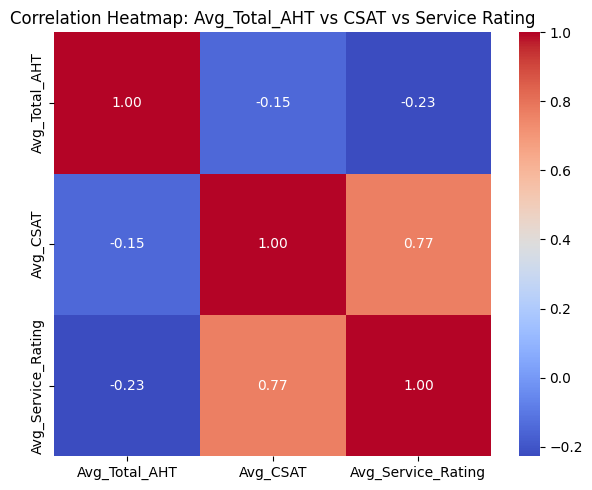

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your merged file
df = pd.read_csv("daily_merged_AHT_CSAT_Service.csv")

# Select the numeric columns we want to correlate
corr_matrix = df[['Avg_Total_AHT', 'Avg_CSAT', 'Avg_Service_Rating']].corr()

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap: Avg_Total_AHT vs CSAT vs Service Rating")
plt.tight_layout()
plt.show()


In [1]:
import pandas as pd
import numpy as np

# -------------------------------
# 1. LOAD FILES
# -------------------------------
perf = pd.read_excel("/content/AHT Customer Service - Agent Performance Analysis v1.xlsx", sheet_name="Master_V1")
survey = pd.read_excel("/content/new_onepager csat .xlsx")  # file is actually Excel even if named .csv

# -------------------------------
# 2. CLEAN PERFORMANCE DATA
# -------------------------------
perf['Date'] = pd.to_datetime(perf['Date'], errors='coerce')

# ---- Calculate Occupancy & Utilization ----
# Protect against divide by zero
perf['Occupancy'] = np.where(perf['Login Time']>0,
                             perf['Total Handle Time'] / perf['Login Time'],
                             np.nan)
perf['Utilization'] = np.where(perf['Login Time']>0,
                               (perf['Total Handle Time'] + perf['Total ACW Time'] + perf['Total Hold Time']) / perf['Login Time'],
                               np.nan)

# ---- Group by Date (average across agents) ----
perf_daily = (
    perf.groupby('Date', as_index=False)
        .agg({
            'Total AHT': 'mean',
            'Total ACW Time': 'mean',
            'Total Hold Time': 'mean',
            'Total SLA': 'mean',
            'Occupancy': 'mean',
            'Utilization': 'mean'
        })
        .rename(columns={
            'Total AHT': 'Avg_Total_AHT',
            'Total ACW Time': 'Avg_Total_ACW_Time',
            'Total Hold Time': 'Avg_Total_Hold_Time',
            'Total SLA': 'Avg_Total_SLA'
        })
)

perf_daily['Date'] = perf_daily['Date'].dt.strftime('%Y-%m-%d')

# -------------------------------
# 3. CLEAN SURVEY DATA
# -------------------------------
# Detect correct date column
date_col = 'Completed Date 2' if 'Completed Date 2' in survey.columns else 'Completed Date'
service_col = 'How would you rate the service you received from the consultant handling your enquiry?'

survey[date_col] = pd.to_datetime(survey[date_col], errors='coerce')

# Convert FCR Yes/No to numeric: Yes=1, No=0 if FCR column exists
if 'FCR' in survey.columns:
    survey['FCR_num'] = survey['FCR'].apply(lambda x: 1 if str(x).strip().lower()=='yes' else 0 if str(x).strip().lower()=='no' else np.nan)
else:
    survey['FCR_num'] = np.nan

survey_daily = (
    survey.groupby(survey[date_col].dt.date)
    .agg({
        'CSAT score': 'mean',
        service_col: 'mean',
        'FCR_num': 'mean'
    })
    .reset_index()
    .rename(columns={
        date_col: 'Date',
        'CSAT score': 'Avg_CSAT',
        service_col: 'Avg_Service_Rating',
        'FCR_num': 'FCR_Rate'
    })
)

survey_daily['Date'] = pd.to_datetime(survey_daily['Date']).dt.strftime('%Y-%m-%d')

# -------------------------------
# 4. MERGE PERFORMANCE & SURVEY
# -------------------------------
merged = pd.merge(perf_daily, survey_daily, on='Date', how='outer').sort_values('Date')

# -------------------------------
# 5. SAVE RESULTS
# -------------------------------
perf_daily.to_csv("performance_daily_metrics.csv", index=False)
survey_daily.to_csv("survey_daily_metrics.csv", index=False)
merged.to_csv("daily_merged_metrics_CSAT_Service_FCR.csv", index=False)

print("✅ Files created:")
print("  • performance_daily_metrics.csv   → AHT, ACW, Hold, SLA, Occupancy, Utilization per day")
print("  • survey_daily_metrics.csv        → Avg_CSAT, Avg_Service_Rating, FCR_Rate per day")
print("  • daily_merged_metrics_CSAT_Service_FCR.csv → combined file ready for correlation")


/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


✅ Files created:
  • performance_daily_metrics.csv   → AHT, ACW, Hold, SLA, Occupancy, Utilization per day
  • survey_daily_metrics.csv        → Avg_CSAT, Avg_Service_Rating, FCR_Rate per day
  • daily_merged_metrics_CSAT_Service_FCR.csv → combined file ready for correlation


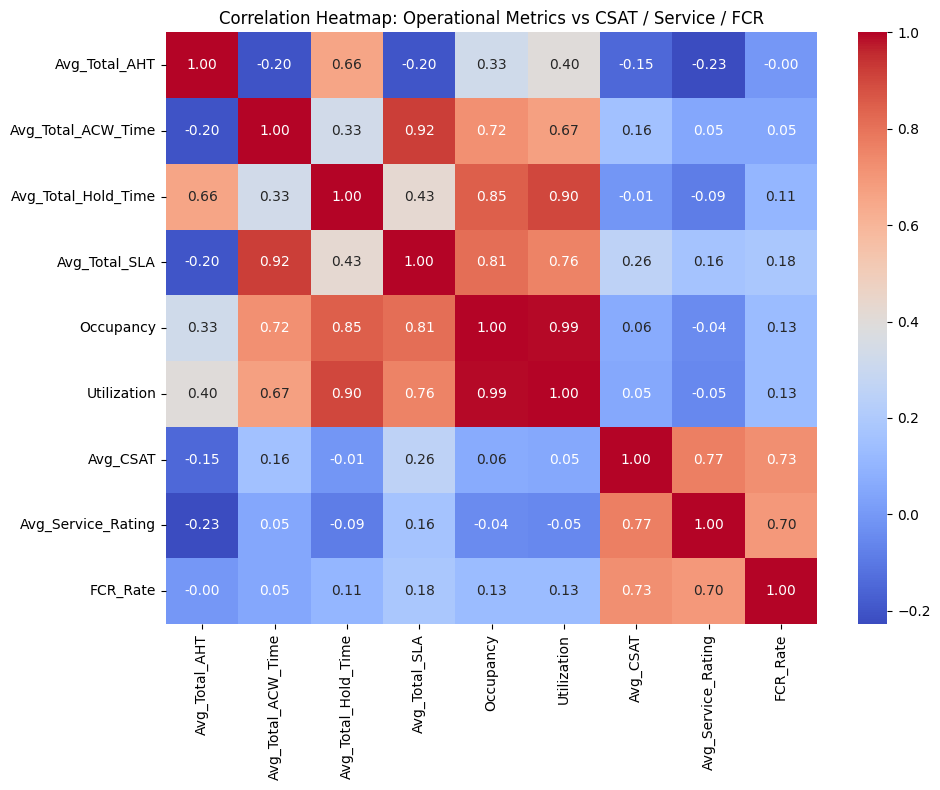

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("daily_merged_metrics_CSAT_Service_FCR.csv")

corr = df[['Avg_Total_AHT','Avg_Total_ACW_Time','Avg_Total_Hold_Time',
           'Avg_Total_SLA','Occupancy','Utilization',
           'Avg_CSAT','Avg_Service_Rating','FCR_Rate']].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap: Operational Metrics vs CSAT / Service / FCR")
plt.tight_layout()
plt.show()


In [4]:
import pandas as pd
import numpy as np

# -------------------------------
# 1. LOAD FILES
# -------------------------------
perf = pd.read_excel("/content/AHT Customer Service - Agent Performance Analysis v1.xlsx", sheet_name="Master_V1")
survey = pd.read_excel("/content/new_onepager csat .xlsx")  # even though named .csv, it’s actually Excel

# -------------------------------
# 2. PERFORMANCE METRICS
# -------------------------------
perf['Date'] = pd.to_datetime(perf['Date'], errors='coerce')

# Calculate Occupancy & Utilization
perf['Occupancy'] = np.where(perf['Login Time'] > 0,
                             perf['Total Handle Time'] / perf['Login Time'],
                             np.nan)
perf['Utilization'] = np.where(perf['Login Time'] > 0,
                               (perf['Total Handle Time'] + perf['Total ACW Time'] + perf['Total Hold Time']) / perf['Login Time'],
                               np.nan)

# Daily averages
perf_daily = (
    perf.groupby('Date', as_index=False)
        .agg({
            'Total AHT': 'mean',
            'Total ACW Time': 'mean',
            'Total Hold Time': 'mean',
            'Total SLA': 'mean',
            'Occupancy': 'mean',
            'Utilization': 'mean'
        })
        .rename(columns={
            'Total AHT': 'Avg_Total_AHT',
            'Total ACW Time': 'Avg_Total_ACW_Time',
            'Total Hold Time': 'Avg_Total_Hold_Time',
            'Total SLA': 'Avg_Total_SLA'
        })
)
perf_daily['Date'] = perf_daily['Date'].dt.strftime('%Y-%m-%d')

# -------------------------------
# 3. SURVEY METRICS
# -------------------------------
# Identify correct date column
date_col = 'Completed Date 2' if 'Completed Date 2' in survey.columns else 'Completed Date'
asat_col = 'How would you rate the service you received from the consultant handling your enquiry?'

survey[date_col] = pd.to_datetime(survey[date_col], errors='coerce')

# Convert FCR to numeric (Yes=1, No=0)
if 'FCR' in survey.columns:
    survey['FCR_num'] = survey['FCR'].apply(lambda x: 1 if str(x).strip().lower()=='yes' else 0 if str(x).strip().lower()=='no' else np.nan)
else:
    survey['FCR_num'] = np.nan

survey_daily = (
    survey.groupby(survey[date_col].dt.date)
    .agg({
        'CSAT score': 'mean',
        asat_col: 'mean',
        'FCR_num': 'mean'
    })
    .reset_index()
    .rename(columns={
        date_col: 'Date',
        'CSAT score': 'Avg_CSAT',
        asat_col: 'Avg_ASAT',          # <-- Renamed here
        'FCR_num': 'FCR_Rate'
    })
)
survey_daily['Date'] = pd.to_datetime(survey_daily['Date']).dt.strftime('%Y-%m-%d')

# -------------------------------
# 4. MERGE & SAVE
# -------------------------------
merged = pd.merge(perf_daily, survey_daily, on='Date', how='outer').sort_values('Date')

perf_daily.to_csv("performance_daily_metrics.csv", index=False)
survey_daily.to_csv("survey_daily_metrics.csv", index=False)
merged.to_csv("daily_merged_metrics_CSAT_ASAT_FCR.csv", index=False)

print("✅ Files created:")
print("  • performance_daily_metrics.csv   → AHT, ACW, Hold, SLA, Occupancy, Utilization per day")
print("  • survey_daily_metrics.csv        → Avg_CSAT, Avg_ASAT, FCR_Rate per day")
print("  • daily_merged_metrics_CSAT_ASAT_FCR.csv → combined file ready for correlation")


/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


✅ Files created:
  • performance_daily_metrics.csv   → AHT, ACW, Hold, SLA, Occupancy, Utilization per day
  • survey_daily_metrics.csv        → Avg_CSAT, Avg_ASAT, FCR_Rate per day
  • daily_merged_metrics_CSAT_ASAT_FCR.csv → combined file ready for correlation
